# Library load 

In [1]:
import sys
sys.path.insert(0, '../scripts/')

import kaggle_credit_default_utilities as kg
import pandas as pd
import numpy as np
import lightgbm as lbm
import sklearn
import shap
shap.initjs()

https://www.kaggle.com/c/home-credit-default-risk/discussion/64821

# Generate DF

In [2]:
df = kg.create_dataset(debug=False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 68s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 97s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 33s
Installments payments df shape: (339587, 26)
Process installments payments - done in 75s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 43s


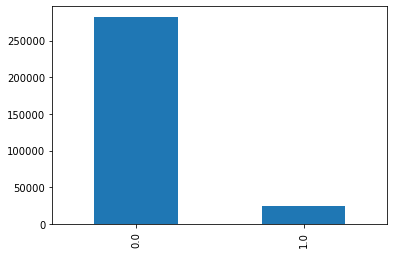

In [3]:
df['TARGET'].value_counts().plot(kind='bar')

In [4]:
import re
df.columns = ["".join (re.sub(r'\W+', '', c) for c in str(x)) for x in df.columns]

In [5]:
df

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           0      100002     1.0            0             0                0   
1           1      100003     0.0            1             0                1   
2           2      100004     0.0            0             1                0   
3           3      100006     0.0            1             0                0   
4           4      100007     0.0            0             0                0   
...       ...         ...     ...          ...           ...              ...   
356250  48739      456221     NaN            1             0                0   
356251  48740      456222     NaN            1             0                1   
356252  48741      456223     NaN            1             1                0   
356253  48742      456224     NaN            0             0                1   
356254  48743      456250     NaN            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0                  0          202500.0    406597.5      24700.5  ...   
1                  0          270000.0   1293502.5      35698.5  ...   
2                  0           67500.0    135000.0       6750.0  ...   
3                  0          135000.0    312682.5      29686.5  ...   
4                  0          121500.0    513000.0      21865.5  ...   
...              ...               ...         ...          ...  ...   
356250             0          121500.0    412560.0      17473.5  ...   
356251             2          157500.0    622413.0      31909.5  ...   
356252             1          202500.0    315000.0      33205.5  ...   
356253             0          225000.0    450000.0      25128.0  ...   
356254             0          135000.0    312768.0      24709.5  ...   

        CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      0.0   
4                                      NaN   
...                                    ...   
356250                                 NaN   
356251                                 NaN   
356252                                 NaN   
356253                                 NaN   
356254                                 0.0   

        CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       0.0   
4                                       NaN   
...                                     ...   
356250                                  NaN   
356251                                  NaN   
356252                                  NaN   
356253                                  NaN   
356254                                  0.0   

        CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      0.0   
4                                      NaN   
...                                    ...   
356250                                 NaN   
356251                                 NaN   
356252                                 NaN   
356253                                 NaN   
356254                                 0.0   

        CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                                      NaN                              NaN   
1                                      NaN                              NaN   
2                                      NaN                              NaN   
3                                      0.0                              0.0   
4                                      NaN                              NaN   
...                      

# Train & stuff

In [6]:
%%time
feature_importance, datasets, model = kg.kfold_lightgbm(df, num_folds = 4, debug=True)

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.800106	training's binary_logloss: 0.233239	valid_1's auc: 0.776563	valid_1's binary_logloss: 0.245088
[400]	training's auc: 0.82446	training's binary_logloss: 0.222919	valid_1's auc: 0.7861	valid_1's binary_logloss: 0.241166
[600]	training's auc: 0.840639	training's binary_logloss: 0.216304	valid_1's auc: 0.789466	valid_1's binary_logloss: 0.239921
[800]	training's auc: 0.853812	training's binary_logloss: 0.210774	valid_1's auc: 0.790735	valid_1's binary_logloss: 0.239446
[1000]	training's auc: 0.865017	training's binary_logloss: 0.205962	valid_1's auc: 0.79136	valid_1's binary_logloss: 0.239256
[1200]	training's auc: 0.875383	training's binary_logloss: 0.201309	valid_1's auc: 0.791831	valid_1's binary_logloss: 0.239123
[1400]	training's auc: 0.88488	training's binary_logloss: 0.196903	valid_1's auc: 0.79199	valid_1's binary_logl

# SHAP

### Margin explainer


[WARNING] Both shap and lightgbm changed some stuff lately, and the code is adjusted for that.

the line

```
 shap.force_plot(explainer.expected_value, shap_value[0,:],sampled_df.iloc[[0]])
```

is now

```
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:],sampled_df.iloc[[0]])
```
Since shap.TreeExplainer() for lightbm now returns a list of numpy array, and the explainer.expected_value returns the two posible scores.

🤷 Shrug ¯\_(ツ)_/¯

In [7]:
feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
sampled_df = sklearn.utils.resample(df[feats], n_samples=500, replace=False)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sampled_df)
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:],sampled_df.iloc[[0]])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Expected value starts low, that means the model starts with the assumption that there's very low risk

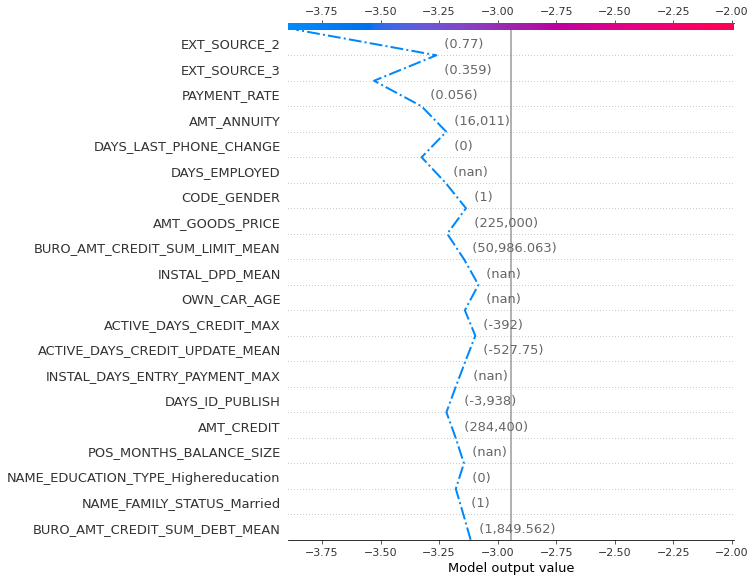

In [8]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][0,:],sampled_df.iloc[[0]], highlight=0)

what the model predicts

In [9]:
model.predict(np.array(sampled_df.iloc[[0]]).reshape(1, -1))

array([0.])

model probabilities

In [10]:
model.predict_proba(np.array(sampled_df.iloc[[0]]).reshape(1, -1))

array([[0.97936087, 0.02063913]])

# Relative importance for a given prediction: The *log*

In [11]:
def get_relative_importance(explainer, names, obv):
    """
    Calculates the relative importance to the overall prediction. This is not translated into probability impact,
    but gives a better idea of the magnitude of a variable in the context of the others.
    
    The provided _explainer_ is applied to the provided observation (in _values_). Then the absolute shap values are 
    sumed and a percent is calculated from that total by feature (without the base value!)
    
    A dataframe is returned with the results
    
    Params:
       * explainer: SHAP explainer
       * names: column names of the features
       * values: column values of the observation
    """
    shap_values_obvs = explainer.shap_values(obv)[1]
    interpretation = pd.DataFrame({"name":names,"value":shap_values_obvs[0]})
    interpretation['impact_from_base'] = interpretation['value'].abs()
    interpretation['impact_from_base'] = (interpretation['impact_from_base'] / interpretation['impact_from_base'].sum())
    return interpretation.sort_values(by=['impact_from_base'], ascending=False)

In [12]:
get_relative_importance(explainer, sampled_df.columns, sampled_df.iloc[[0]])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


name     value  impact_from_base
31                                EXT_SOURCE_2 -0.598000          0.156251
32                                EXT_SOURCE_3  0.266132          0.069537
244                               PAYMENT_RATE -0.202797          0.052989
6                                  AMT_ANNUITY -0.105473          0.027559
80                      DAYS_LAST_PHONE_CHANGE  0.105261          0.027504
..                                         ...       ...               ...
406  PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN  0.000000          0.000000
405    PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN  0.000000          0.000000
403   PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN  0.000000          0.000000
395           PREV_NAME_CONTRACT_TYPE_nan_MEAN  0.000000          0.000000
467      PREV_NAME_GOODS_CATEGORY_Animals_MEAN  0.000000          0.000000

[795 rows x 3 columns]

Your actual predict call could look a bit like this

In [13]:
def predict_value(model, explainer, names, values):
    prediction = model.predict(np.array(values).reshape(1, -1))
    explanation = get_relative_importance(explainer, names, values)
    return {'prediction':prediction, 'explanation':explanation.to_dict(orient='records')}

In [14]:
predict_value(model, explainer,sampled_df.columns, sampled_df.iloc[[0]])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


{'prediction': array([0.]),
 'explanation': [{'name': 'EXT_SOURCE_2',
   'value': -0.5980003902489911,
   'impact_from_base': 0.15625110512569643},
  {'name': 'EXT_SOURCE_3',
   'value': 0.2661316842465707,
   'impact_from_base': 0.06953736226689648},
  {'name': 'PAYMENT_RATE',
   'value': -0.20279749160646432,
   'impact_from_base': 0.05298881521972829},
  {'name': 'AMT_ANNUITY',
   'value': -0.10547314066825204,
   'impact_from_base': 0.02755900340404539},
  {'name': 'DAYS_LAST_PHONE_CHANGE',
   'value': 0.10526132699981057,
   'impact_from_base': 0.027503658758265263},
  {'name': 'DAYS_EMPLOYED',
   'value': -0.10193410641576446,
   'impact_from_base': 0.026634291611133964},
  {'name': 'CODE_GENDER',
   'value': -0.0874884840685752,
   'impact_from_base': 0.022859805017509897},
  {'name': 'AMT_GOODS_PRICE',
   'value': 0.08012885886693916,
   'impact_from_base': 0.020936813678678577},
  {'name': 'BURO_AMT_CREDIT_SUM_LIMIT_MEAN',
   'value': -0.07194711436985073,
   'impact_from_base

Or send that second part to *logging.debug(explanation)* for example, in a different call if reponse time is critical

## Alterative: Explain probs

Keep in mind is an alternative method and won't match 1-1

In [15]:
explainer = shap.TreeExplainer(model, sampled_df, model_output='probability',feature_perturbation = "interventional")
shap_values = explainer.shap_values(sampled_df)

100%|===================| 499/500 [02:46<00:00]        

#### Remember this:

```
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:],sampled_df.iloc[[0]])
```

#### Well doesn't apply here. Why? Because reasons.

I always liked xbgoost more anyway...

In [16]:
shap.force_plot(explainer.expected_value, shap_values[0,:], sampled_df.iloc[[0]])

In [17]:
explainer.expected_value

0.08051784955514285

In [18]:
tmpdf = pd.DataFrame({"name":sampled_df.columns,"probs":explainer.shap_values(sampled_df.iloc[[0]])[0]})
tmpdf['abs_probs'] = tmpdf['probs'].abs() * 100
tmpdf.sort_values(by=['abs_probs'], ascending=False)

name     probs  abs_probs
31                      EXT_SOURCE_2 -0.026642   2.664213
244                     PAYMENT_RATE -0.008602   0.860195
6                        AMT_ANNUITY -0.004933   0.493312
10                     DAYS_EMPLOYED -0.004061   0.406127
0                        CODE_GENDER -0.004050   0.404995
..                               ...       ...        ...
504  PREV_NAME_PRODUCT_TYPE_nan_MEAN  0.000000   0.000000
269      BURO_MONTHS_BALANCE_MAX_MAX  0.000000   0.000000
500     PREV_NAME_PORTFOLIO_nan_MEAN  0.000000   0.000000
496    PREV_NAME_PORTFOLIO_Cars_MEAN  0.000000   0.000000
794                         CC_COUNT  0.000000   0.000000

[795 rows x 3 columns]

# Back to margins mode

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sampled_df)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


# Feature importance

Original VS shap

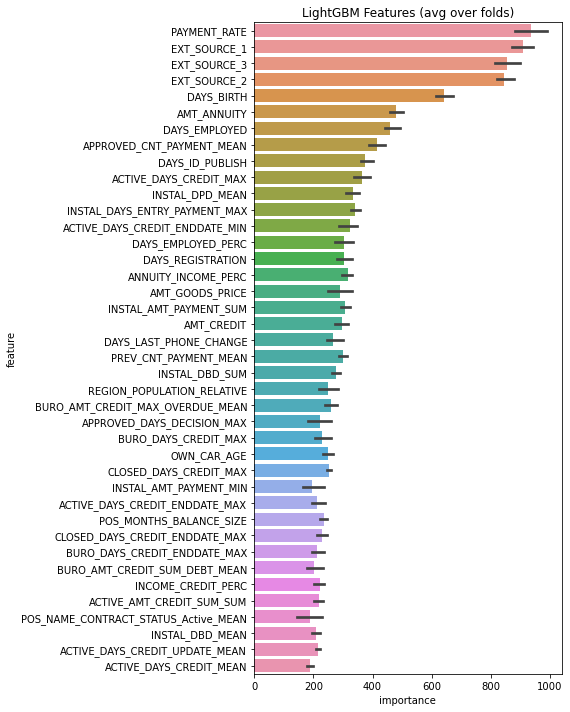

In [20]:
kg.display_importances(feature_importance)

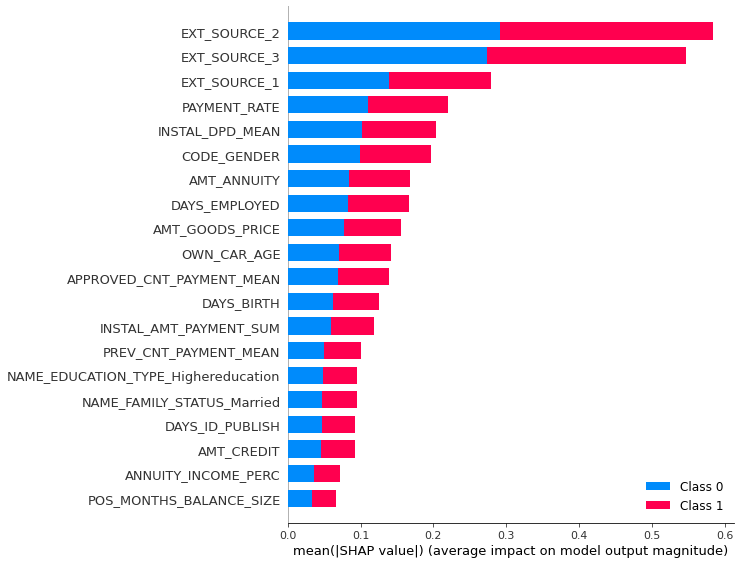

In [21]:
shap.summary_plot(shap_values, sampled_df, plot_type="bar")

In this case, the variables with the biggest impact are (what appears to be) external sources... ? Is that a good sign?

# Dependence Plot

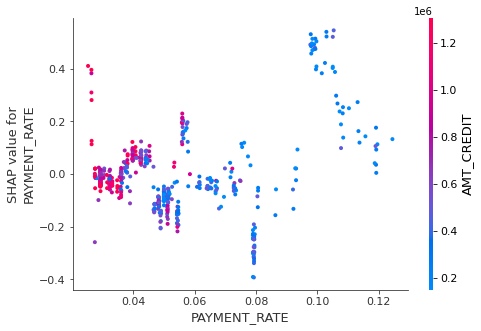

In [26]:
shap.dependence_plot("PAYMENT_RATE", shap_values[0], sampled_df)

Payment_rate indicates that how it impacts the model varies a lot.

<0.05 is a sighly-to-none negative impact, the same with >0.09

Between that interval, the impact is positive, and overall, independet of ext_source_3

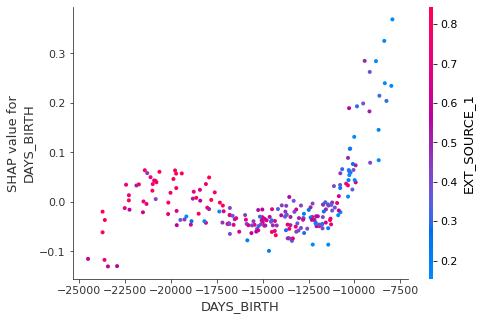

In [27]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("DAYS_BIRTH", shap_values[0], sampled_df)

The older you are, the less propension to default.

Between X-Y, almost nothing

Younger than X is about how much does impact your propension to default

# Trainingset breakdown


This is basically applying shap to the whole datset, mind that.

**warning**: Don't attempt to plot the **whole** dataset, because no one want's to plot > 300k observations here. We are using a sample of 100 here.

In [31]:
# visualize the training set predictions
sampled_df = sklearn.utils.resample(df[feats], n_samples=100, replace=False)
shap_values = explainer.shap_values(sampled_df)
shap.force_plot(explainer.expected_value[0], shap_values[0], sampled_df)

# Overall feature effect

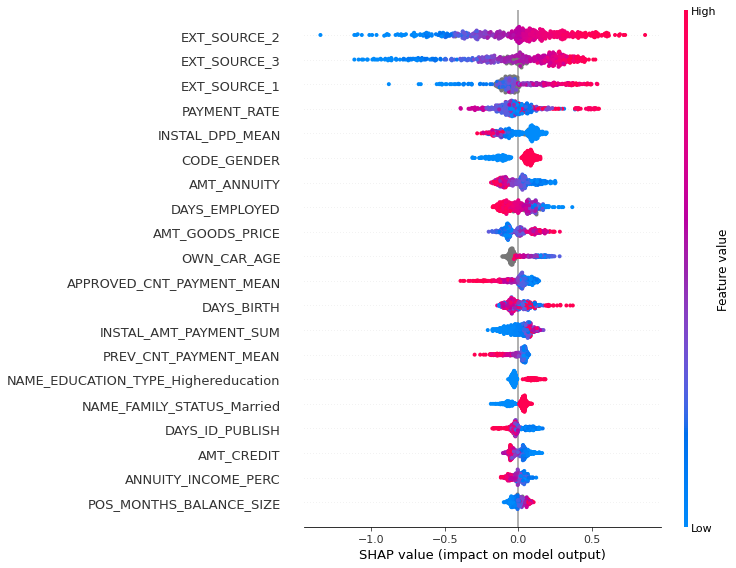

In [29]:
# summarize the effects of all the features
shap.summary_plot(shap_values[0], sampled_df)